# Chapter 18: Quantum Machine Learning

---

**Prerequisites:**
- Python 3.8+
- Qiskit 2.1.2
- See `Chapter02_Software.ipynb` for installation instructions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_ibm_runtime import Estimator
from qiskit_aer import Aer
from qiskit.quantum_info import SparsePauliOp
from IPython.display import display
from scipy.optimize import minimize
from Chapter18_QML_functions import create_parametric_circuit, pqc_predict_batch,huber_loss, cosine_fidelity_01

from Chapter03_StructuralOptimization_functions import (truss3x2, truss3x3,TrussFEM)

## Function to learn, training data and test data

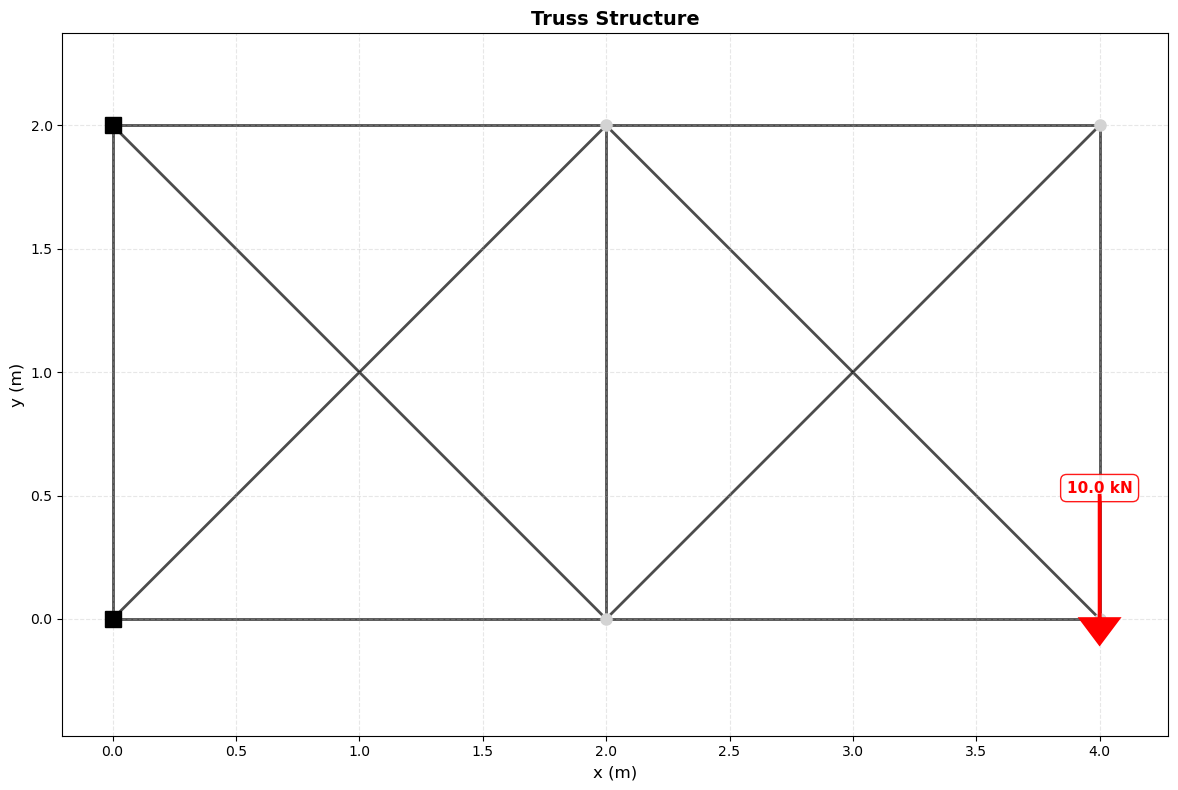

Initial compliance (all members present): 8.0522
Initial weight (all members present): 198.7126
-0.9871924404685716 -0.498356324231674


In [13]:
fem_model = truss3x2()
fem_model.plot_truss()
n_qubits = len(fem_model.elements)  # Number of truss members
n_layers = 3

def trussCompliance(area_fractions):
    area = area_fractions * fem_model.A  # Scale areas
    d, valid = fem_model.solve(area)
    compliance = fem_model.loads.T @ d
    return compliance

initialCompliance = trussCompliance(np.ones(n_qubits))
initialWeight = np.sum(fem_model.A*fem_model.L*fem_model.rho)
print(f"Initial compliance (all members present): {initialCompliance:.4f}")
print(f"Initial weight (all members present): {initialWeight:.4f}")
n_train = 50
n_tests = 10
x_train = np.random.uniform(1e-3, 1, size=(n_train, n_qubits)) # area fractions
compliance_values = []
for i in range(n_train):
    area_fraction = x_train[i,:] 
    compliance = trussCompliance(area_fraction)
    compliance_values.append(compliance)

compliance_max = initialCompliance*50
compliance_min = initialCompliance
# Normalize y_train to [-1, 1]
y_train = [2 * (y - compliance_min) / (compliance_max - compliance_min) - 1 for y in compliance_values]
y_train = np.clip(y_train, -1, 1)
print(min(y_train), max(y_train))
x_test = np.random.uniform(1e-3, 1, size=(n_tests, n_qubits))  # area fractions
compliance_test = []
for i in range(n_tests):
    area_fraction = x_test[i,:]  
    compliance = trussCompliance(area_fraction)
    compliance_test.append(compliance)
y_test = [2 * (y - compliance_min) / (compliance_max - compliance_min) - 1 for y in compliance_test]

## Parameterized QC

In [14]:
np.random.seed(42) 

qc = create_parametric_circuit(n_qubits, n_layers)
observable = SparsePauliOp.from_list([("Z" + "I" * (n_qubits - 1), 1.0)])


#display(qc.draw('mpl'))

## Simulator, loss function

In [15]:
nShots = 5000
backend = Aer.get_backend("statevector_simulator") 
estimator = Estimator(backend, options={"default_shots": nShots})

def loss_theta(theta_vec):
    preds = pqc_predict_batch(theta_vec, x_train, qc, observable, estimator)
    return huber_loss(preds, y_train)


## Training

In [ ]:
theta0 = np.random.normal(0, 0.1, size=n_layers * n_qubits * 3)
res = minimize(
    loss_theta,
    theta0,
    method="COBYLA",
    options={"maxiter": max(500, n_qubits + 10)}
)

theta_star = res.x
print("Training done.")
print("Final loss:", loss_theta(theta_star))


## Check errors using test data 

In [ ]:
preds = pqc_predict_batch(theta_star, x_test, qc, observable, estimator)
print("First 5 preds:", preds[:5])
print("First 5 y:", y_test[:5])

mae = np.mean(np.abs(preds - y_test))
rmse = np.sqrt(np.mean((preds - y_test)**2))
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

First 5 preds: [-0.482  -0.5248 -0.5828 -0.4536 -0.5396]
First 5 y: [np.float64(-0.9399291630946863), np.float64(-0.8480283204914747), np.float64(-0.7201929191011401), np.float64(-0.8231742719845511), np.float64(-0.7969134539041545)]
MAE: 0.3833, RMSE: 0.4007


## Optimize the structure

In [ ]:
# # 2. Optimize design using trained surrogate
# def predict_compliance(areas):
#     """Use trained QC to predict compliance"""
#     areas_2d = areas.reshape(1, -1)  # Shape (1, n_qubits)
#     result = pqc_predict_batch(theta_star, areas_2d, qc, observable, estimator)
#     return float(result[0])  # Return scalar

# def weight(area_fractions):
#     area = area_fractions * fem_model.A  # Scale areas
#     return np.sum(area * fem_model.L * fem_model.rho)

# # 3. Minimize compliance subject to weight constraint

# desiredWeightFraction = 0.5
# areasFraction0 = np.ones(n_qubits)   
# initialWeight = weight(areasFraction0)
# res_design = minimize(
#     predict_compliance,
#     areasFraction0,
#     method="COBYLA",
#     constraints={'type': 'ineq', 'fun': lambda a: desiredWeightFraction - weight(a)/initialWeight  },
#     options={"maxiter": 200}
# )

# optimal_areas_fraction = res_design.x
# print("Optimal area fractions:", optimal_areas_fraction)
# print("Predicted compliance at optimal design:", predict_compliance(optimal_areas_fraction))
# print("Weight fraction at optimal design:", weight(optimal_areas_fraction)/initialWeight)